#  Использование одномерных сверток в PyTorch

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы: 
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann 
* https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
* https://pytorch.org/docs/stable/generated/torch.nn.MaxPool1d.html#torch.nn.MaxPool1d
* https://wandb.ai/wandb_fc/wb-tutorials/reports/Tutorial-Text-Classification-Using-CNNs--Vmlldzo0NTIxNDI5
* https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

## Задачи для совместного разбора

1\. Изучите принцип работы одномерных сверточных слоев в `torch`

![1d conv](https://raw.githubusercontent.com/krzjoa/krzjoa.github.io/master/assets/img/2020-10-03-ts-and-torch-1/conv1d.gif)

![conv1d](https://www.macnica.co.jp/business/ai/blog/files/image5_2.png)

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Загрузите данные из файла `ts.csv`. Используя модель, состоящую из одного одномерного сверточного слоя, решите задачу предсказания $y_t$ по `k` предыдущим точкам временного ряда $x_{t-k}...x_{t-1}$. Исследуйте значения $k\in[1, 7]$. Для каждого $k$ выведите на экран итоговое значение функции потерь и веса ядра свертки. Визуализируйте исходный временной ряд и полученные прогнозы.

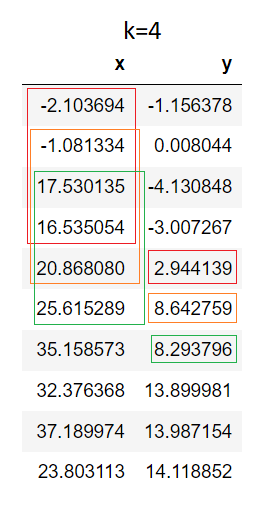
- [ ] Проверено на семинаре

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('ts.csv')
x = df.iloc[:, 0].values
x = (x - x.mean()) / x.std()

In [5]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, k):
        self.x = x
        self.k = k
        self.data = []
        self.targets = []
        for i in range(k, len(x)):
            self.data.append(x[i-k:i])
            self.targets.append(x[i])
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.targets[idx], dtype=torch.float32)

In [6]:
results = []
for k in range(1, 8):
    dataset = TimeSeriesDataset(x, k)
    train_size = int(0.8 * len(dataset))
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset)-train_size])
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    class SimpleConv1D(nn.Module):
        def __init__(self, k):
            super().__init__()
            self.conv1 = nn.Conv1d(1, 1, k)
            self.flatten = nn.Flatten()
        def forward(self, x):
            x = x.unsqueeze(1)
            x = self.conv1(x)
            x = self.flatten(x)
            return x.squeeze(1)
    model = SimpleConv1D(k)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    for epoch in range(100):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
    model.eval()
    test_loss = 0
    predictions = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            predictions.extend(outputs.cpu().numpy())
    test_loss /= len(test_loader)
    kernel_weights = model.conv1.weight.data.squeeze().cpu().numpy()
    print(f"k={k}: Final Loss = {test_loss:.4f}")
    print(f"Kernel weights: {kernel_weights}")
    results.append({'k': k, 'loss': test_loss, 'kernel': kernel_weights, 'predictions': np.array(predictions)})

k=1: Final Loss = 0.1530
Kernel weights: 0.9162358045578003
k=2: Final Loss = 0.1927
Kernel weights: [0.14703196 0.7877151 ]
k=3: Final Loss = 0.1329
Kernel weights: [-0.15154012  0.20883207  0.8336449 ]
k=4: Final Loss = 0.1854
Kernel weights: [-0.16023704 -0.02976196  0.26820463  0.82194054]
k=5: Final Loss = 0.1873
Kernel weights: [-0.15844652 -0.04986043  0.01377882  0.2767736   0.77326995]
k=6: Final Loss = 0.2179
Kernel weights: [-0.13567674 -0.08440354  0.04844052 -0.02594633  0.28606278  0.7392599 ]
k=7: Final Loss = 0.1180
Kernel weights: [-0.0869093  -0.10893828 -0.01393455  0.05505    -0.01094332  0.27754325
  0.71273375]


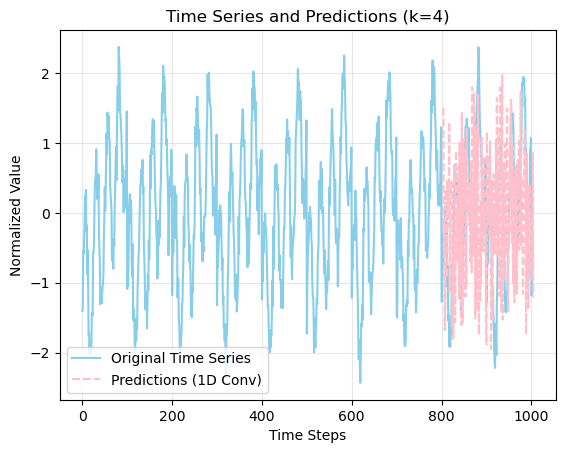

In [14]:
best_k = 4
idx = next(i for i, r in enumerate(results) if r['k'] == best_k)
full_pred = np.full_like(x, np.nan, dtype=float)
start = len(x) - len(results[idx]['predictions'])
full_pred[start:] = results[idx]['predictions']
plt.plot(x, label='Original Time Series', color='skyblue')
plt.plot(full_pred, label='Predictions (1D Conv)', color='pink', linestyle='--')
plt.title(f'Time Series and Predictions (k={best_k})')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

<p class="task" id="2"></p>

2\. Загрузите файл `PV_Elec_Gas2.csv`. Опишите класс `ElectricityDataset`, который разбивает данные на окна в соответствии со следующей схемой:

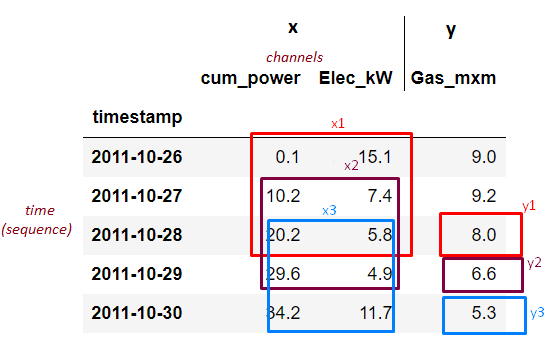

Разбейте набор данных на обучающую и тестовую выборку. Для теста оставьте данные за 2019 год.

- [ ] Проверено на семинаре

In [143]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader

In [145]:
df = pd.read_csv('PV_Elec_Gas2.csv')
df['timestamp'] = pd.to_datetime(df.iloc[:, 0])
df = df.drop(df.columns[0], axis=1)
df.head()

,cum_power,Elec_kW,Gas_mxm,timestamp
0,0.1,15.1,9.0,2011-10-26
1,10.2,7.4,9.2,2011-10-27
2,20.2,5.8,8.0,2011-10-28
3,29.6,4.9,6.6,2011-10-29
4,34.2,11.7,5.3,2011-10-30


In [146]:
X_features = ['cum_power', 'Elec_kW']
Y_feature = 'Gas_mxm'

In [147]:
X_df = df[X_features].values
Y_df = df[Y_feature].values

In [148]:
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
train_mask = df['timestamp'] < pd.to_datetime('2019-01-01')
test_mask = df['timestamp'] >= pd.to_datetime('2019-01-01')

In [149]:
X_train = scaler_X.fit_transform(X_df[train_mask])
X_test = scaler_X.transform(X_df[test_mask])
Y_train = scaler_Y.fit_transform(Y_df[train_mask].reshape(-1, 1)).ravel()
Y_test = scaler_Y.transform(Y_df[test_mask].reshape(-1, 1)).ravel()

In [163]:
class ElectricityDataset(Dataset):
    def __init__(self, X_data, Y_data, window_size=3):
        self.X_data = X_data
        self.Y_data = Y_data
        self.window_size = window_size
        self.num_samples = len(X_data) - window_size + 1
    def __len__(self):
        return self.num_samples
    def __getitem__(self, idx):
        x_window = self.X_data[idx:idx + self.window_size]
        x = torch.tensor(x_window.T, dtype=torch.float32)        
        y = torch.tensor(self.Y_data[idx + self.window_size - 1], dtype=torch.float32)
        return x, y

<p class="task" id="3"></p>

3\. Решите задачу предсказания столбца `Gas_mxm` на основе столбцов `cum_power` и `Elec_kW` с использованием одномерных сверток. Для оптимизации используйте мини-пакетный градиентный спуск с использованием `DataLoader`. Обратите внимание, что при создании `DataLoader` вы не можете перемешивать данные.

Постройте график изменения значения функции потерь на обучающем и тестовом множестве в зависимости от номера эпохи. Визуализируйте на одном графике прогнозы модели и предсказываемый временной ряд.

- [ ] Проверено на семинаре

In [151]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [152]:
window_size = 3
train_dataset = ElectricityDataset(X_train, Y_train, window_size)
test_dataset = ElectricityDataset(X_test, Y_test, window_size)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [162]:
class ConvModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * window_size, 16)
        self.fc2 = nn.Linear(16, 1)
        self.relu2 = nn.ReLU()
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = out.view(out.size(0), -1)  
        out = self.fc1(out)
        out = self.relu2(out)
        out = self.fc2(out)
        return out.squeeze(-1)

In [154]:
device = torch.device('cpu')
model = ConvModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.MSELoss()

In [155]:
num_epochs = 200
train_losses = []
test_losses = []
best_test_loss = float('inf')
patience = 20
trigger_times = 0

In [156]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x_batch.size(0)
    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item() * x_batch.size(0)
    test_loss /= len(test_dataset)
    test_losses.append(test_loss)

    if test_loss < best_test_loss:
        best_test_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f'Раннее прекращение на эпохе {epoch + 1}')
            break

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch [10/200], Train Loss: 0.3709, Test Loss: 0.3007
Epoch [20/200], Train Loss: 0.3600, Test Loss: 0.2785
Epoch [30/200], Train Loss: 0.3606, Test Loss: 0.2657
Epoch [40/200], Train Loss: 0.3542, Test Loss: 0.2688
Epoch [50/200], Train Loss: 0.3506, Test Loss: 0.2889
Epoch [60/200], Train Loss: 0.3513, Test Loss: 0.2876
Epoch [70/200], Train Loss: 0.3465, Test Loss: 0.3138
Раннее прекращение на эпохе 71


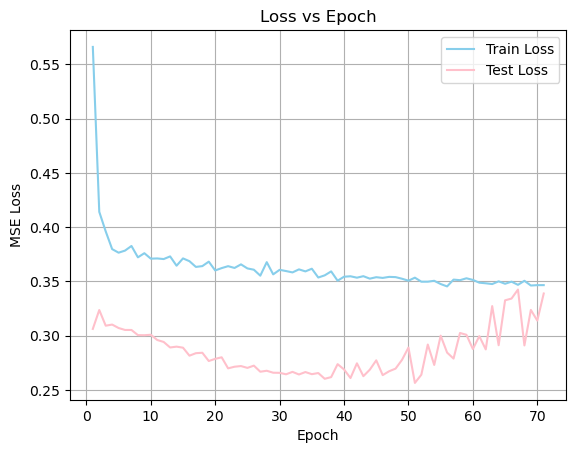

In [160]:
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss', color='skyblue')
plt.plot(range(1, len(test_losses)+1), test_losses, label='Test Loss', color='pink')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [158]:
model.eval()
test_preds = []
test_true = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        test_preds.extend(outputs.cpu().numpy())
        test_true.extend(y_batch.cpu().numpy())

test_preds_original = scaler_Y.inverse_transform(np.array(test_preds).reshape(-1, 1)).ravel()
test_true_original = scaler_Y.inverse_transform(np.array(test_true).reshape(-1, 1)).ravel()

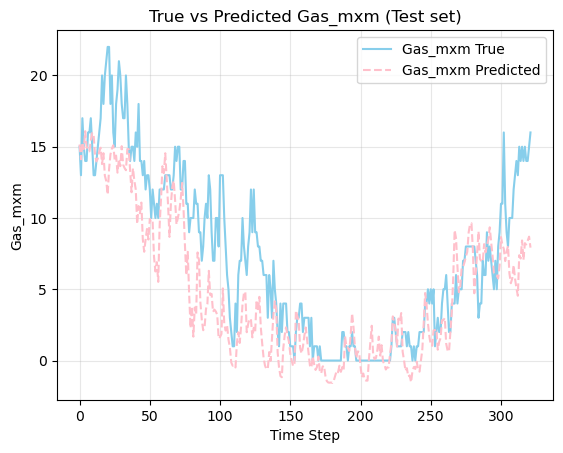

In [161]:
plt.plot(test_true_original, label='Gas_mxm True', color='skyblue')
plt.plot(test_preds_original, label='Gas_mxm Predicted', linestyle='--', color='pink')
plt.xlabel('Time Step')
plt.ylabel('Gas_mxm')
plt.title('True vs Predicted Gas_mxm (Test set)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

<p class="task" id="4"></p>

4\. Считайте файлы `polarity/positive_reviews.txt` (положительные обзоры на фильмы) и `polarity/negative_reviews.txt` (отрицательные обозоры на фильмы) и разбейте на обучающую и тестовую выборку. Выполните предобработку текста и создайте Vocab на основе обучающей выборки (токен - слово). Выведите на экран количество токенов в полученном словаре. 

Создайте класс `PolarityDataset` и реализуйте метод `__getitem__` таким образом, чтобы он возвращал набор индексов токенов (слов) для текста и метки классов для этих текстов. Создайте два объекта класса `PolarityDataset` для обучающей и тестовой выборки. Выведите на экраны количество элементов и распределение данных по классам в каждом из них.

- [ ] Проверено на семинаре

In [1]:
import numpy as np
from torch.utils.data import Dataset
from collections import Counter
import re

In [2]:
def load_reviews(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return [line.strip() for line in f if line.strip()]

In [3]:
positive_reviews = load_reviews('polarity/positive_reviews.txt')
negative_reviews = load_reviews('polarity/negative_reviews.txt')

In [4]:
positive_split = int(0.8 * len(positive_reviews))
negative_split = int(0.8 * len(negative_reviews))

positive_train = positive_reviews[:positive_split]
positive_test = positive_reviews[positive_split:]
negative_train = negative_reviews[:negative_split]
negative_test = negative_reviews[negative_split:]

In [5]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text) 
    return text.split()

all_train_texts = positive_train + negative_train
preprocessed_train_texts = [preprocess_text(text) for text in all_train_texts]

In [6]:
word_counts = Counter(word for text in preprocessed_train_texts for word in text)
vocab = {word: idx + 1 for idx, (word, _) in enumerate(word_counts.items())} 
vocab['<PAD>'] = 0 
print(f"Количество токенов в словаре: {len(vocab)}")

Количество токенов в словаре: 18211


In [7]:
class PolarityDataset(Dataset):
    def __init__(self, reviews, labels, vocab):
        self.reviews = reviews
        self.labels = labels
        self.vocab = vocab
        self.preprocessed_reviews = [preprocess_text(review) for review in reviews]
        self.data = self._create_dataset()

    def _create_dataset(self):
        data = []
        for tokens in self.preprocessed_reviews:
            indices = [self.vocab.get(word, 0) for word in tokens]  
            data.append(indices)
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float32)

In [8]:
train_reviews = positive_train + negative_train
test_reviews = positive_test + negative_test
train_labels = [1] * len(positive_train) + [0] * len(negative_train)  # 1 - positive, 0 - negative
test_labels = [1] * len(positive_test) + [0] * len(negative_test)

train_dataset = PolarityDataset(train_reviews, train_labels, vocab)
test_dataset = PolarityDataset(test_reviews, test_labels, vocab)

In [9]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Train class distribution: Positive = {train_labels.count(1)}, Negative = {train_labels.count(0)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Test class distribution: Positive = {test_labels.count(1)}, Negative = {test_labels.count(0)}")
print(f"Positive reviews total: {len(positive_reviews)}, Negative reviews total: {len(negative_reviews)}")

Train dataset size: 8528
Train class distribution: Positive = 4264, Negative = 4264
Test dataset size: 2134
Test class distribution: Positive = 1067, Negative = 1067
Positive reviews total: 5331, Negative reviews total: 5331


<p class="task" id="5"></p>

5\. Решите задачу классификации текстов обзоров с использованием одномерных сверток. Для преобразования последовательности индексов в последовательность векторов используйте слой `nn.Embedding`. Обратите внимание, что `nn.Conv1d` ожидает на вход трехмерный тензор размерности `(batch, embedding_dim, seq_len)`. Выведите на экран отчет по классификации для обучающей и тестовой выборки после завершения процесса обучения. Добейтесь accuracy на тестовой выборке не менее 70%.

- [ ] Проверено на семинаре

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

In [11]:
def collate_fn(batch):
    sequences, labels = zip(*batch)
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)  
    labels = torch.stack(labels)
    return sequences_padded, labels

In [12]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [13]:
class ConvTextClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, output_dim=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.conv1 = nn.Conv1d(emb_dim, 32, 3)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(32, output_dim)
        self.dropout = nn.Dropout(0.6)

    def forward(self, x):
        embedded = self.embedding(x)                
        embedded = embedded.permute(0, 2, 1)        
        conv_out = self.conv1(embedded)             
        conv_out = self.bn1(conv_out)
        conv_out = self.relu(conv_out)
        pooled = self.pool(conv_out)                 
        pooled = pooled.squeeze(-1)                  
        dropped = self.dropout(pooled)
        out = self.fc(dropped)                       
        return out

In [14]:
vocab_size = len(vocab)
embedding_dim = 100
device = torch.device('cpu')
model = ConvTextClassifier(vocab_size, embedding_dim).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-2)
criterion = nn.BCEWithLogitsLoss()

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

In [15]:
num_epochs = 100
train_losses, test_losses = [], []
best_test_acc = 0
trigger_times, patience = 0, 10
best_test_loss = float('inf')

In [16]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for sequences, labels in train_loader:
        sequences, labels = sequences.to(device), labels.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * sequences.size(0)
    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for sequences, labels in test_loader:
            sequences, labels = sequences.to(device), labels.to(device).unsqueeze(1)
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * sequences.size(0)
            preds = torch.sigmoid(outputs) > 0.5
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    test_loss /= len(test_dataset)
    test_losses.append(test_loss)
    test_acc = np.mean(np.array(all_preds) == np.array(all_labels))

    if test_acc > best_test_acc:
        best_test_acc = test_acc
        trigger_times = 0
    else:
        trigger_times += 1

    if test_loss > best_test_loss + 0.05:
        print(f"Early stopping at epoch {epoch + 1} due to test loss increase")
        break
    best_test_loss = min(best_test_loss, test_loss)

    if trigger_times >= patience:
        print(f"Early stopping at epoch {epoch + 1} due to no test accuracy improvement")
        break

    scheduler.step(test_loss)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs} Train Loss: {train_loss:.4f} Test Loss: {test_loss:.4f} Test Acc: {test_acc:.4f}")

print(f"Best test accuracy: {best_test_acc:.4f}")

Epoch 5/100 Train Loss: 0.6876 Test Loss: 0.6842 Test Acc: 0.5455
Epoch 10/100 Train Loss: 0.6636 Test Loss: 0.6725 Test Acc: 0.6068
Epoch 15/100 Train Loss: 0.6548 Test Loss: 0.6641 Test Acc: 0.6143
Epoch 20/100 Train Loss: 0.6401 Test Loss: 0.6575 Test Acc: 0.6326
Epoch 25/100 Train Loss: 0.6304 Test Loss: 0.6551 Test Acc: 0.6321
Epoch 30/100 Train Loss: 0.6274 Test Loss: 0.6525 Test Acc: 0.6167
Early stopping at epoch 32 due to no test accuracy improvement
Best test accuracy: 0.6406


In [17]:
model_save_path = "polarity_classifier_weights.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Веса модели сохранены в файл: {model_save_path}")
# model.load_state_dict(torch.load(model_save_path))

Веса модели сохранены в файл: polarity_classifier_weights.pth


Построение матрицы ошибок с помощью Seaborn...


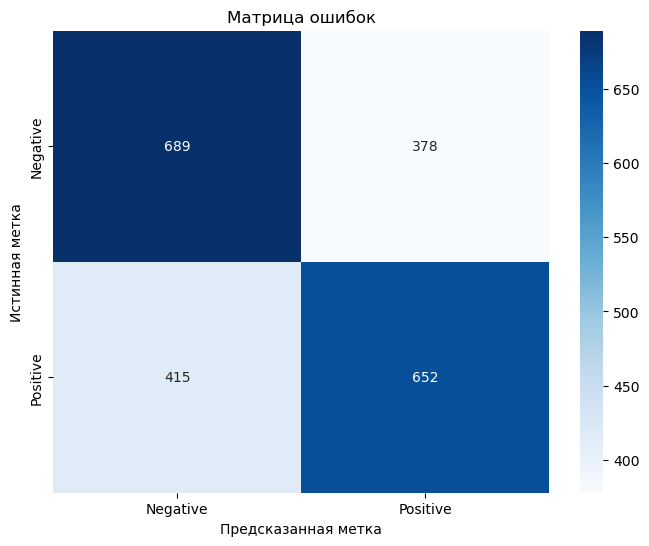

In [19]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics 

def make_confusion_matrix_sns(loader, model, class_names, device):
    with torch.inference_mode():
        predictions = []
        true_labels = []
        
        for sequences, labels in loader:
            sequences = sequences.to(device)
            outputs = model(sequences)

            preds = torch.sigmoid(outputs) > 0.5

            predictions.extend(preds.cpu().numpy().flatten())
            true_labels.extend(labels.numpy().flatten())

    cm = metrics.confusion_matrix(true_labels, predictions)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, 
                annot=True,    
                fmt='d',       
                cmap='Blues', 
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Предсказанная метка')
    plt.ylabel('Истинная метка')
    plt.title('Матрица ошибок')
    plt.show()

print("Построение матрицы ошибок с помощью Seaborn...")
make_confusion_matrix_sns(test_loader, model, ['Negative', 'Positive'], device)

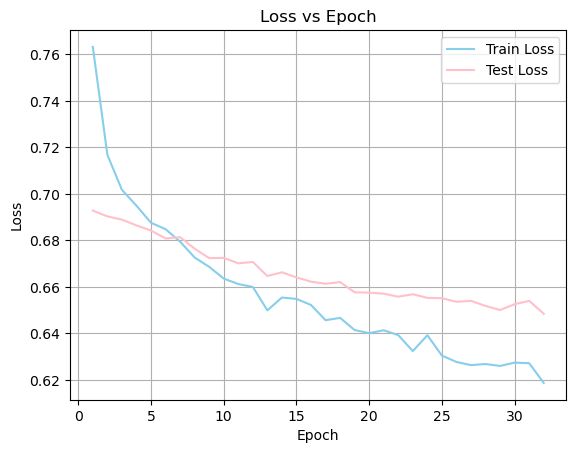

In [20]:
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss', color='skyblue')
plt.plot(range(1, len(test_losses)+1), test_losses, label='Test Loss', color='pink')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

<p class="task" id="6"></p>

6\. Придумайте небольшой отзыв, прогоните его через модель и выведите метку предсказанного класса (позитивный или негативный). Сделайте это для явно позитивного и явно негативного отзыва.

- [ ] Проверено на семинаре

In [186]:
import torch
import re

In [187]:
def predict_review(model, vocab, review_text, device):
    def preprocess_text(text):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        return text.split()

    tokens = preprocess_text(review_text)
    indices = [vocab.get(word, 0) for word in tokens]  
    sequence = torch.tensor(indices, dtype=torch.long).unsqueeze(0)  

    max_len = max([len(x) for x in train_dataset.data]) if hasattr(train_dataset, 'data') else 100
    if len(indices) > max_len:
        sequence = sequence[:, :max_len]
    elif len(indices) < max_len:
        padding = torch.zeros(1, max_len - len(indices), dtype=torch.long)
        sequence = torch.cat((sequence, padding), dim=1)

    model.eval()
    with torch.no_grad():
        sequence = sequence.to(device)
        output = model(sequence)
        prediction = torch.sigmoid(output) > 0.5
        return "Positive" if prediction.item() else "Negative"


In [189]:
positive_review = "I absolutely loved this movie, it was amazing!"
print(f"Positive review: '{positive_review}'")
print(f"Predicted class: {predict_review(model, vocab, positive_review, device)}\n")

Positive review: 'I absolutely loved this movie, it was amazing!'
Predicted class: Positive



In [190]:
negative_review = "This film was terrible and I hated every moment."
print(f"Negative review: '{negative_review}'")
print(f"Predicted class: {predict_review(model, vocab, negative_review, device)}")

Negative review: 'This film was terrible and I hated every moment.'
Predicted class: Negative


## Обратная связь
- [ ] Хочу получить обратную связь по решению